# Livelike Basic Usage Demo

- ACS 2019 - 2023 5-Year Estimates
- UP Baseline Constraints: employment, industry, occupation, education
- Knoxville City Central, TN PUMA (`4701501`)

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-03-20T14:44:29.562195-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import pathlib

import geopandas as gpd
import numpy as np
import pandas as pd
from likeness_vitals.vitals import get_censusapikey, match
from pymedm import PMEDM, diagnostics

from livelike import acs, est, homesim

%watermark -w
%watermark -iv

Watermark: 2.5.0

geopandas      : 1.0.1
numpy          : 2.2.4
pymedm         : 2.2.3
pandas         : 2.2.3
livelike       : 1.4.8.dev3+geea70e8
likeness_vitals: 0.1.dev3+g2392110.d20250320



### Read Census API Key

In [3]:
key = get_censusapikey(pathlib.Path("..", ""))

### Create baseline PUMA representation

The `puma` class stores a representation of the PUMA based on ACS constraints. It contains the microdata and block group/tract estimates and standard errors required for P-MEDM.

#### Target PUMA - Knoxville City Central, TN

In [4]:
p = "4701501"

##### Create baseline PUMA representation

In [5]:
# recommend enabling ``cache`` for 2023+
pup = acs.puma(p, year=2023, censusapikey=key, cache=True)

## Spatial Allocation with P-MEDM

### Create P-MEDM object

**Inputs:**

- ACS vintage year.
- The PUMS household response serial numbers (`serial`).
- The PUMS household sample weights (`wt`)
- Individual-level constraints (`est_ind`)
- Tract and block group level constraints (`est_trt`, `est_bg`)
- Tract and block group level standard errors (`se_trt`, `se_bg`)

In [6]:
pmd = PMEDM(
    pup.year,
    pup.est_ind.index,
    pup.wt,
    pup.est_ind,
    pup.est_g1,
    pup.est_g2,
    pup.se_g1,
    pup.se_g2,
)

### Solve P-MEDM problem

In [7]:
pmd.solve()

In [8]:
# objective value
float(pmd.res.state.value)

-1.9071858768243724

### Diagnostics

As a quick diagnostic, we measure the proportion of synthetic constraint estimates fitting the ACS 90% margins of error (MOEs), or the `moe_fit_rate`:

In [9]:
diagnostics.moe_fit_rate(pup.est_ind, pup.est_g2, pup.se_g2, pmd.almat)

{'Ycomp':                          constraint   acs        pmedm         err    moe  \
 470930001001             population  1516  1540.808205   24.808205  260.0   
 470930001002             population  1134  1201.077097   67.077097  217.0   
 470930008001             population  1695  1796.041236  101.041236  566.0   
 470930008002             population  1054  1078.459949   24.459949  285.0   
 470930008003             population  1907  1893.221063   13.778937  439.0   
 ...                             ...   ...          ...         ...    ...   
 470930069022  hht_nonfam_hhsize_7pm    29    10.947984   18.052016   44.0   
 470930069031  hht_nonfam_hhsize_7pm     0     2.179176    2.179176   14.0   
 470930069032  hht_nonfam_hhsize_7pm    22    24.008132    2.008132   36.0   
 470930070001  hht_nonfam_hhsize_7pm     0     0.000150    0.000150   14.0   
 470930070002  hht_nonfam_hhsize_7pm     0     0.000393    0.000393   14.0   
 
               in_moe  
 470930001001    True  
 4709

## Population Synthesis

Use Lovelace and Ballas' (2013) "Truncate, Replicate, Sample" method to create 30 realizations of the residential synthetic population:

In [10]:
hs = homesim.synthesize(
    pmd.almat,
    pup.est_ind,
    pup.est_g2,
    pup.sporder,
    random_state=int(pup.fips),
)
hs

,sim,geoid,count
h_id,,,
2019GQ0013655,0,470930001001,6
2019GQ0015912,0,470930001001,4
2019GQ0032247,0,470930001001,2
2019GQ0052860,0,470930001001,2
2019GQ0062180,0,470930001001,2
...,...,...,...
2023HU1425255,29,470930070002,1
2023HU1431982,29,470930070002,1
2023HU1444747,29,470930070002,2


## Application 1: Creating Agents for `actlike`

For this example, we'll focus on tabulating 10th grade public school students. We will identify matching person-level records from the PUMS by querying the Census Microdata API on two criteria:

- Public School Student {`SCH` : 2}
- Attending 10th Grade {`SCHG` : 12}

We set up our API query by separating these conditions with an `&`, as:

In [11]:
# API query
q1 = "SCH=2&SCHG=12"

In [12]:
seg1_extract = acs.extract_pums_segment_ids(p, "person", q1, year=2023)

Then, create the agents by merging the extract with our synthetic population (`hs`): 

In [13]:
seg1 = hs.merge(
    seg1_extract.loc[:, ["SERIALNO", "p_id"]], left_on="h_id", right_on="SERIALNO"
)
seg1

,sim,geoid,count,SERIALNO,p_id
0,0,470930008001,2,2023HU0000649,2023HU000064905
1,0,470930008002,1,2020HU0046790,2020HU004679002
2,0,470930008002,6,2021HU0680527,2021HU068052703
3,0,470930008002,1,2023HU0446894,2023HU044689402
4,0,470930008003,1,2019HU0442114,2019HU044211403
...,...,...,...,...,...
10862,29,470930070001,2,2023HU1297821,2023HU129782103
10863,29,470930070001,6,2023HU1379028,2023HU137902802
10864,29,470930070002,1,2019HU0563061,2019HU056306102
10865,29,470930070002,1,2020HU0516217,2020HU051621703


## Application 2: Tabulating Segments

Sometimes we require more specific criteria to select segments than what is available in our P-MEDM constraints (i.e., occupation class, NAICS code, hours worked). We can fetch additional PUMS variables related to the constraints from the Census Microdata API query and then link them to our synthetic populations.

For this example, we'll estimate the counts of full-time workers in K-12 schools, specifically:

- Employed full time and currently at work (`ESR == 1`)
- Working in elementary or secondary schools (`NAICSP == 6111`)
- In a preschool, kindergarten, primary, or secondary school teaching position (`{OCCP : [2300, 2310, 2320]}`)
- Working 40+ hours per week (`WKHP >= 40`)

Begin by generating the new API query:

In [14]:
q2 = "ESR=1&NAICSP=6111&OCCP=2300:2320&WKHP=40:999"

A `>=` operator does not seem to be availble for CMD API requests, so `40:999` is used in its place.

Now make the API extract:

In [15]:
seg2 = acs.extract_pums_segment_ids(p, "person", q2, year=2023, censusapikey=key)

This returns a DataFrame containing the household ID (`SERIALNO`) and household structure (`SPORDER`) for each matching respondent in the PUMS:

In [16]:
seg2

,SERIALNO,SPORDER,ESR,NAICSP,OCCP,WKHP,p_id
1,2019HU0097682,2,1,6111,2310,45,2019HU009768202
2,2019HU0289957,2,1,6111,0230,40,2019HU028995702
3,2019HU0447417,1,1,6111,2300,40,2019HU044741701
4,2019HU0561641,1,1,6111,2300,50,2019HU056164101
5,2019HU0598017,1,1,6111,2310,50,2019HU059801701
6,2019HU0691164,1,1,6111,2310,40,2019HU069116401
7,2019HU0803948,1,1,6111,2310,40,2019HU080394801
8,2019HU0859840,1,1,6111,2320,50,2019HU085984001
9,2019HU0936196,1,1,6111,2310,40,2019HU093619601
10,2019HU0936196,2,1,6111,2310,40,2019HU093619602


Tabulation:

In [17]:
tab_seg2 = est.tabulate_by_serial(hs, seg2["SERIALNO"], "person")
tab_seg2

sim  geoid       
0    470930001001    18
     470930001002    11
     470930008001     8
     470930008002    15
     470930008003     3
                     ..
29   470930069022     1
     470930069031     2
     470930069032     6
     470930070001     8
     470930070002     1
Length: 2640, dtype: int64

### 2a. Comparing Segment Estimates Across Census Areas

This estimation method is more suited for geodemographic classification.  We'll stick with our K-12 educator segment from the previous example here. 

A necessary first step is to **normalize the estimates** to effectively relate census areas. The normalization procedure estimates the _proportion_ of the segment within each block group.  

This one-liner generates the total block group population and household counts by simulation number:

In [18]:
totalpop = est.tabulate_by_count(hs, pup.est_ind["population"])
totalpop

sim  geoid       
0    470930001001    780.601029
     470930001002    623.325948
     470930008001    655.580008
     470930008002    636.731222
     470930008003    956.239625
                        ...    
29   470930069022    670.617303
     470930069031    363.618711
     470930069032    537.073324
     470930070001    779.185559
     470930070002    539.332513
Name: population, Length: 2850, dtype: float64

With `totalpop` in hand, we can then normalize the estimates: 

In [19]:
prop_seg2 = est.to_prop(tab_seg2, totalpop)
prop_seg2

sim  geoid       
0    470930001001    0.023059
     470930001002    0.017647
     470930008001    0.012203
     470930008002    0.023558
     470930008003    0.003137
                       ...   
29   470930014003    0.000000
     470930026002    0.000000
     470930067002    0.000000
     470930068004    0.000000
     470930069011    0.000000
Length: 2850, dtype: float64

### 2b. Monte Carlo Estimation

When comparing census areas, it is often more convenient to use estimates that are one-to-one. To achieve this, we can use Monte Carlo estimation to aggregate the simulation-level estimates (as well as gauge uncertainty). 

To generate the Monte Carlo estimates:

In [20]:
mc_prop_seg2 = est.monte_carlo_estimate(prop_seg2)
mc_prop_seg2

,est,se
geoid,,
470930001001,0.022874,0.000152
470930001002,0.016506,0.000787
470930008001,0.012270,0.000101
470930008002,0.023094,0.000265
470930008003,0.003131,0.000025
...,...,...
470930069022,0.001512,0.000018
470930069031,0.005535,0.000044
470930069032,0.011160,0.000120


#### Example 3b: Mapping the Estimates

In [21]:
knox_bg = acs.extract_geographies(2023, targets=pd.unique(hs["geoid"]), geo="bg")

In [22]:
mc_prop_seg2.index.name = "GEOID"

In [23]:
knox_bg["mc_prop_seg2"] = match(knox_bg, mc_prop_seg2.est)

<Axes: >

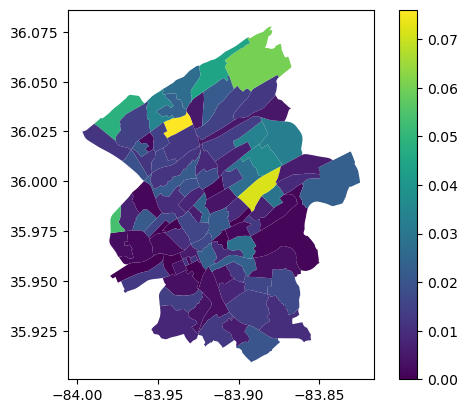

In [24]:
# plot!
knox_bg.plot(column="mc_prop_seg2", legend=True)